OUTLIER DETECTION AND CLEANING - IO CPU STRESS ANALYSIS (ISOLATION FOREST)

📊 Processing Block Count Latency Device with Isolation Forest:
  🔍 CPUSTRESS:
    ✅ Cleaned 21 outliers using 9 features (5% contamination)
  🔍 BASELINE:
    ✅ Cleaned 25 outliers using 9 features (5% contamination)

📊 Processing Read Bytes with Isolation Forest:
  🔍 CPUSTRESS:
    ✅ Cleaned 23 outliers using 4 features (5% contamination)
  🔍 BASELINE:
    ✅ Cleaned 0 outliers using 3 features (5% contamination)

📊 Processing Write Bytes with Isolation Forest:
  🔍 CPUSTRESS:
    ✅ Cleaned 24 outliers using 4 features (5% contamination)
  🔍 BASELINE:
    ✅ Cleaned 25 outliers using 3 features (5% contamination)

COMPREHENSIVE IO CPU STRESS ANALYSIS - ISOLATION FOREST

🔄 Analyzing Block Count Latency Device...


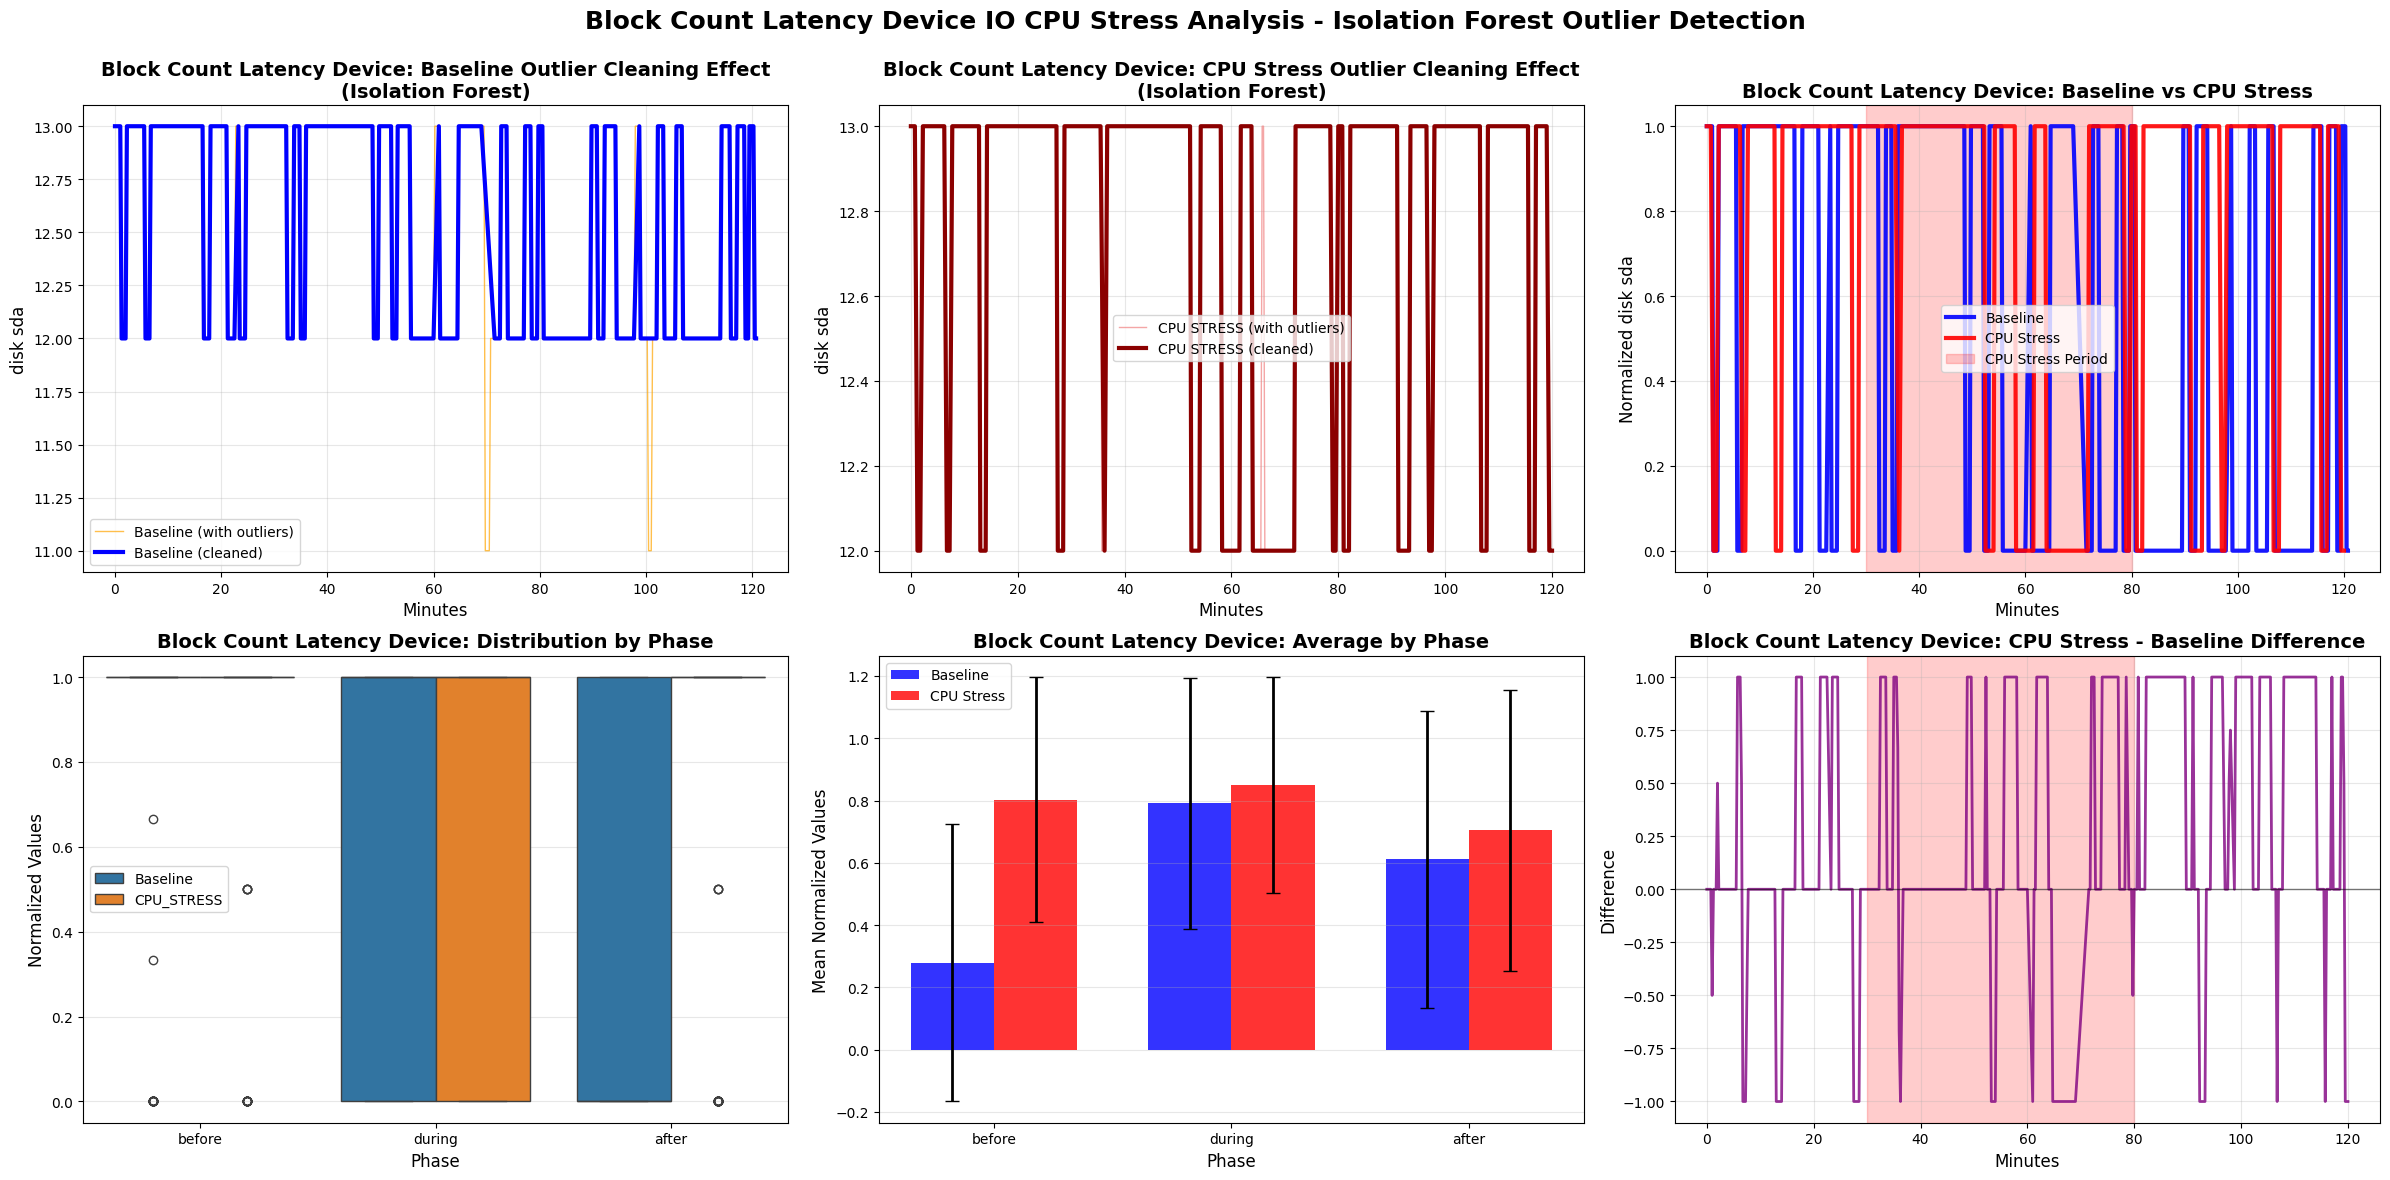


BLOCK COUNT LATENCY DEVICE - IO CPU STRESS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.2791  0.4457  0.0  1.0
before  0.7917  0.4032  0.0  1.0
during  0.6119  0.4767  0.0  1.0

📊 CPU STRESS STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.8031  0.3929  0.0  1.0
before  0.8500  0.3467  0.0  1.0
during  0.7040  0.4511  0.0  1.0

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -1.20, p=  0.2307 (❌ NOT SIGNIFICANT)
  DURING  : t= -1.99, p=  0.0475 (✅ SIGNIFICANT)
  AFTER   : t=-11.20, p=  0.0000 (✅ SIGNIFICANT)

📈 CPU STRESS IMPACT ON IO (% CHANGE):
  BEFORE  :   +7.37% (↗️ INCREASE)
  DURING  :  +15.04% (↗️ INCREASE)
  AFTER   : +187.71% (↗️ INCREASE)

🔄 Analyzing Read Bytes...


KeyError: 'openeuler-swap'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load all IO datasets
df_block_count_latency_device = pd.read_csv("block_count_latency_device.csv")
df_read_bytes = pd.read_csv("read_bytes.csv")
df_write_bytes = pd.read_csv("write_bytes.csv")

df_baseline_block_count_latency_device = pd.read_csv("../../baseline/IO related/block_count_latency_device.csv")
df_baseline_read_bytes = pd.read_csv("../../baseline/IO related/read_bytes.csv")
df_baseline_write_bytes = pd.read_csv("../../baseline/IO related/write_bytes.csv")

# Add source labels for CPU STRESS experiment
df_block_count_latency_device["source"] = "CPU_STRESS"
df_read_bytes["source"] = "CPU_STRESS"
df_write_bytes["source"] = "CPU_STRESS"

df_baseline_block_count_latency_device["source"] = "BASELINE"
df_baseline_read_bytes["source"] = "BASELINE"
df_baseline_write_bytes["source"] = "BASELINE"

# Convert to datetime
df_block_count_latency_device["Time"] = pd.to_datetime(df_block_count_latency_device["Time"])
df_read_bytes["Time"] = pd.to_datetime(df_read_bytes["Time"])
df_write_bytes["Time"] = pd.to_datetime(df_write_bytes["Time"])

df_baseline_block_count_latency_device["Time"] = pd.to_datetime(df_baseline_block_count_latency_device["Time"])
df_baseline_read_bytes["Time"] = pd.to_datetime(df_baseline_read_bytes["Time"])
df_baseline_write_bytes["Time"] = pd.to_datetime(df_baseline_write_bytes["Time"])

delay = 30
duration = 50

# Synchronize test datasets with baseline timeline
time_offset = df_baseline_block_count_latency_device["Time"].min() - df_block_count_latency_device["Time"].min()
df_block_count_latency_device["Time"] += time_offset
df_read_bytes["Time"] += time_offset
df_write_bytes["Time"] += time_offset

# Convert timeline to minutes
all_dfs = [
    df_block_count_latency_device, df_read_bytes, df_write_bytes,
    df_baseline_block_count_latency_device, df_baseline_read_bytes, df_baseline_write_bytes
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# ORIGINAL DATASETS DICTIONARY
original_datasets = {
    'Block Count Latency Device': {'cpustress': df_block_count_latency_device, 'baseline': df_baseline_block_count_latency_device},
    'Read Bytes': {'cpustress': df_read_bytes, 'baseline': df_baseline_read_bytes},
    'Write Bytes': {'cpustress': df_write_bytes, 'baseline': df_baseline_write_bytes}
}

# ISOLATION FOREST OUTLIER DETECTION FOR IO CPU STRESS ANALYSIS
def remove_outliers_isolation_forest_io_cpustress(df, contamination=0.05):
    """
    IO CPU stress specific outlier detection using Isolation Forest
    Moderate contamination (5%) as CPU stress can affect IO patterns significantly
    """
    df_clean = df.copy()
    outlier_stats = {}
    
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    if len(numeric_cols) == 0:
        return df_clean, outlier_stats
    
    if len(numeric_cols) == 1:
        main_col = numeric_cols[0]
        series = df[main_col].fillna(method='ffill').fillna(method='bfill')
        
        features = []
        features.append(series.values)
        
        if len(series) > 15:
            # CPU stress affects IO in bursts - capture these patterns
            features.append(series.rolling(5, center=True).mean().fillna(method='ffill').fillna(method='bfill').values)
            features.append(series.rolling(10, center=True).mean().fillna(method='ffill').fillna(method='bfill').values)
            features.append(series.rolling(5, center=True).std().fillna(0).values)
            features.append(series.diff().fillna(0).values)
            features.append(series.diff().diff().fillna(0).values)
            
            # CPU-IO specific: detect processing bursts and idle periods
            features.append(series.rolling(7, center=True).max().fillna(method='ffill').fillna(method='bfill').values)
            features.append(series.rolling(7, center=True).min().fillna(method='ffill').fillna(method='bfill').values)
            
            # Burst detection - periods of high activity followed by low activity
            burst_indicator = (series > series.rolling(15, center=True).quantile(0.75)).astype(int)
            features.append(burst_indicator.fillna(0).values)
        
        feature_matrix = np.column_stack(features)
    else:
        feature_matrix = df[numeric_cols].fillna(method='ffill').fillna(method='bfill').values
    
    scaler = StandardScaler()
    feature_matrix_scaled = scaler.fit_transform(feature_matrix)
    
    iso_forest = IsolationForest(
        contamination=contamination,
        n_estimators=150,
        random_state=42,
        n_jobs=-1,
        max_features=1.0
    )
    
    iso_forest.fit(feature_matrix_scaled)
    outlier_predictions = iso_forest.predict(feature_matrix_scaled)
    outlier_mask = outlier_predictions == -1
    
    for col in numeric_cols:
        outlier_stats[col] = {
            'count': outlier_mask.sum(),
            'percentage': (outlier_mask.sum() / len(df[col])) * 100,
            'method': 'isolation_forest_io_cpustress'
        }
        
        df_clean.loc[outlier_mask, col] = np.nan
        df_clean[col] = df_clean[col].interpolate(method='linear')
    
    outlier_stats['_summary'] = {
        'total_outliers': outlier_mask.sum(),
        'contamination_rate': contamination,
        'method': 'isolation_forest_io_cpustress',
        'features_used': feature_matrix.shape[1],
        'n_estimators': 150
    }
    
    return df_clean, outlier_stats

# APPLY OUTLIER CLEANING
print("=" * 80)
print("OUTLIER DETECTION AND CLEANING - IO CPU STRESS ANALYSIS (ISOLATION FOREST)")
print("=" * 80)

datasets_clean = {}
all_outlier_stats = {}

for dataset_name, dataset_pair in original_datasets.items():
    print(f"\n📊 Processing {dataset_name} with Isolation Forest:")
    
    datasets_clean[dataset_name] = {}
    all_outlier_stats[dataset_name] = {}
    
    for source_type, df in dataset_pair.items():
        print(f"  🔍 {source_type.upper().replace('_', ' ')}:")
        
        df_clean, stats = remove_outliers_isolation_forest_io_cpustress(df, contamination=0.05)
        
        datasets_clean[dataset_name][source_type] = df_clean
        all_outlier_stats[dataset_name][source_type] = stats
        
        total_outliers = stats['_summary']['total_outliers']
        features_used = stats['_summary']['features_used']
        print(f"    ✅ Cleaned {total_outliers} outliers using {features_used} features (5% contamination)")

# NORMALIZATION FUNCTION
def normalize_df_io(df, columns):
    result = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            result[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            result[col] = 0
    return result

# ADD PHASE COLUMN 
def add_phase_column(df, delay_minutes, duration_minutes):
    df = df.copy()
    df['phase'] = 'before'  
    df.loc[(df['Minutes'] >= delay_minutes) & (df['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'  
    df.loc[df['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after' 
    return df

# ANALYSIS AND PLOT FUNCTION FOR IO CPU STRESS
def analyze_and_plot_io_dataset_wide(dataset_name, cpustress_df, baseline_df, delay_minutes, duration_minutes):
    numeric_cols = [col for col in cpustress_df.select_dtypes(include=[np.number]).columns 
                   if col not in ['Time', 'Minutes']]
    
    cpustress_norm = normalize_df_io(cpustress_df, numeric_cols)
    baseline_norm = normalize_df_io(baseline_df, numeric_cols)
    
    main_metric = numeric_cols[0] if numeric_cols else None
    
    if main_metric is None:
        print(f"No numeric columns found for {dataset_name}")
        return None
    
    cpustress_norm = add_phase_column(cpustress_norm, delay_minutes, duration_minutes)
    baseline_norm = add_phase_column(baseline_norm, delay_minutes, duration_minutes)
    
    stats_baseline = baseline_norm.groupby('phase')[main_metric].agg(['mean', 'std', 'min', 'max'])
    stats_cpustress = cpustress_norm.groupby('phase')[main_metric].agg(['mean', 'std', 'min', 'max'])
    
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm[main_metric],
        'CPU_STRESS': cpustress_norm[main_metric],
        'Minutes': baseline_norm['Minutes'],
        'phase': baseline_norm['phase'],
        'difference': cpustress_norm[main_metric] - baseline_norm[main_metric]
    })
    
    t_tests = {}
    for phase in ['before', 'during', 'after']:
        data = df_combined[df_combined['phase'] == phase]
        t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['CPU_STRESS'].dropna())
        t_tests[phase] = {'t': t_stat, 'p': p_value}
    
    impact = {}
    for phase in ['before', 'during', 'after']:
        baseline_mean = stats_baseline.loc[phase, 'mean']
        cpustress_mean = stats_cpustress.loc[phase, 'mean']
        impact[phase] = ((cpustress_mean - baseline_mean) / baseline_mean) * 100 if baseline_mean != 0 else float('inf')
    
    # PLOTTING
    fig = plt.figure(figsize=(24, 12))
    
    # 1. Baseline outlier cleaning effect
    plt.subplot(2, 3, 1)
    original_baseline = original_datasets[dataset_name]['baseline']
    
    plt.plot(original_baseline['Minutes'], original_baseline[main_metric], 
             label='Baseline (with outliers)', color='orange', alpha=0.7, linewidth=1)
    plt.plot(baseline_df['Minutes'], baseline_df[main_metric], 
             label='Baseline (cleaned)', linewidth=3, color='blue')
    plt.title(f'{dataset_name}: Baseline Outlier Cleaning Effect\n(Isolation Forest)', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'{main_metric}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. CPU STRESS outlier cleaning effect
    plt.subplot(2, 3, 2)
    original_cpustress = original_datasets[dataset_name]['cpustress']
    
    plt.plot(original_cpustress['Minutes'], original_cpustress[main_metric], 
             label='CPU STRESS (with outliers)', alpha=0.7, color='lightcoral', linewidth=1)
    plt.plot(cpustress_df['Minutes'], cpustress_df[main_metric], 
             label='CPU STRESS (cleaned)', linewidth=3, color='darkred')
    plt.title(f'{dataset_name}: CPU Stress Outlier Cleaning Effect\n(Isolation Forest)', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'{main_metric}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. Timeline comparison
    plt.subplot(2, 3, 3)
    plt.plot(baseline_norm['Minutes'], baseline_norm[main_metric], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(cpustress_norm['Minutes'], cpustress_norm[main_metric], 
             label='CPU Stress', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="CPU Stress Period")
    plt.title(f"{dataset_name}: Baseline vs CPU Stress", fontsize=14, fontweight='bold')
    plt.xlabel("Minutes", fontsize=12)
    plt.ylabel(f"Normalized {main_metric}", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # 4. Box plot by phase
    plt.subplot(2, 3, 4)
    box_data = pd.melt(df_combined[['Baseline', 'CPU_STRESS', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{dataset_name}: Distribution by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Normalized Values', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=10)
    
    # 5. Statistics by phase
    plt.subplot(2, 3, 5)
    phases = ['before', 'during', 'after']
    x = np.arange(len(phases))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, stats_baseline['mean'], width, label='Baseline', alpha=0.8, color='blue')
    bars2 = plt.bar(x + width/2, stats_cpustress['mean'], width, label='CPU Stress', alpha=0.8, color='red')
    
    plt.errorbar(x - width/2, stats_baseline['mean'], yerr=stats_baseline['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    plt.errorbar(x + width/2, stats_cpustress['mean'], yerr=stats_cpustress['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    
    plt.title(f'{dataset_name}: Average by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Mean Normalized Values', fontsize=12)
    plt.xticks(x, phases)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Difference over time
    plt.subplot(2, 3, 6)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{dataset_name}: CPU Stress - Baseline Difference', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel('Difference', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'{dataset_name} IO CPU Stress Analysis - Isolation Forest Outlier Detection', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()
    
    print(f"\n{'='*80}")
    print(f"{dataset_name.upper()} - IO CPU STRESS ANALYSIS RESULTS")
    print(f"{'='*80}")
    
    print(f"\n📊 BASELINE STATISTICS BY PHASE:")
    print(stats_baseline.round(4))
    
    print(f"\n📊 CPU STRESS STATISTICS BY PHASE:")
    print(stats_cpustress.round(4))
    
    print(f"\n🔬 STATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        sig = "✅ SIGNIFICANT" if test['p'] < 0.05 else "❌ NOT SIGNIFICANT"
        print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} ({sig})")
    
    print(f"\n📈 CPU STRESS IMPACT ON IO (% CHANGE):")
    for phase, change in impact.items():
        direction = "↗️ INCREASE" if change > 0 else "↘️ DECREASE" if change < 0 else "→ NO CHANGE"
        print(f"  {phase.upper():8}: {change:+7.2f}% ({direction})")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_cpustress': stats_cpustress,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined,
        'main_metric': main_metric
    }

# RUN ANALYSIS 
print(f"\n{'='*80}")
print("COMPREHENSIVE IO CPU STRESS ANALYSIS - ISOLATION FOREST")
print(f"{'='*80}")

analysis_results = {}

for dataset_name in datasets_clean.keys():
    print(f"\n🔄 Analyzing {dataset_name}...")
    
    cpustress_clean = datasets_clean[dataset_name]['cpustress']
    baseline_clean = datasets_clean[dataset_name]['baseline']
    
    analysis_results[dataset_name] = analyze_and_plot_io_dataset_wide(
        dataset_name, 
        cpustress_clean, 
        baseline_clean, 
        delay, 
        duration
    )

# FINAL SUMMARY
print(f"\n{'='*100}")
print("COMPREHENSIVE IO CPU STRESS IMPACT SUMMARY")
print(f"{'='*100}")

summary_table = []
for dataset_name, results in analysis_results.items():
    if results:
        for phase in ['before', 'during', 'after']:
            summary_table.append({
                'IO_Metric': dataset_name,
                'Phase': phase,
                'Impact (%)': f"{results['impact'][phase]:+.1f}%",
                'P-Value': f"{results['t_tests'][phase]['p']:.4f}",
                'Significant': 'YES' if results['t_tests'][phase]['p'] < 0.05 else 'NO',
                'T-Statistic': f"{results['t_tests'][phase]['t']:.2f}"
            })

if summary_table:
    summary_df = pd.DataFrame(summary_table)
    print(summary_df.to_string(index=False, col_space=12))


## block count latency device

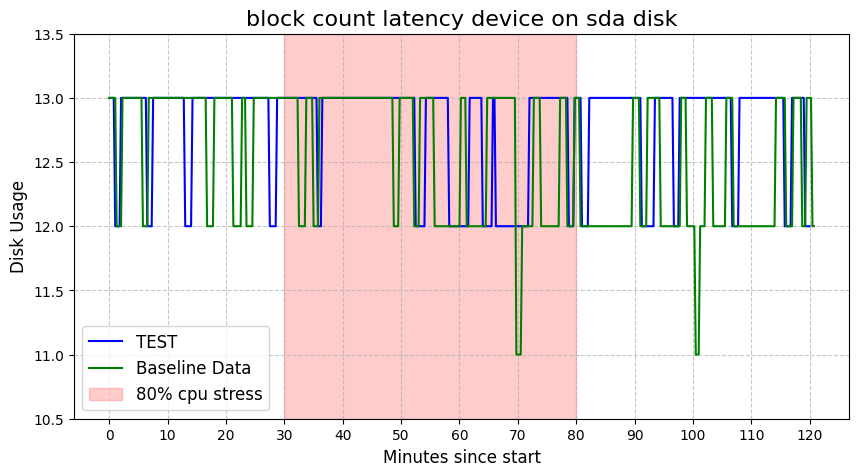

In [13]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(df_block_count_latency_device["Minutes"], df_block_count_latency_device["disk sda"], 
         label="TEST", color='blue', linewidth=1.5)
plt.plot(df_baseline_block_count_latency_device["Minutes"], df_baseline_block_count_latency_device["disk sda"], 
         label="Baseline Data", color='green', linewidth=1.5)
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="80% cpu stress")
plt.title("block count latency device on sda disk", fontsize=16)
plt.xlabel("Minutes since start", fontsize=12)
plt.ylabel("Disk Usage", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(10.5, 13.5)
plt.legend(loc='best', fontsize=12)
plt.xticks(np.arange(0, max(df_block_count_latency_device["Minutes"].max(), 
                           df_baseline_block_count_latency_device["Minutes"].max())+1, 10))

plt.show()

## read bytes

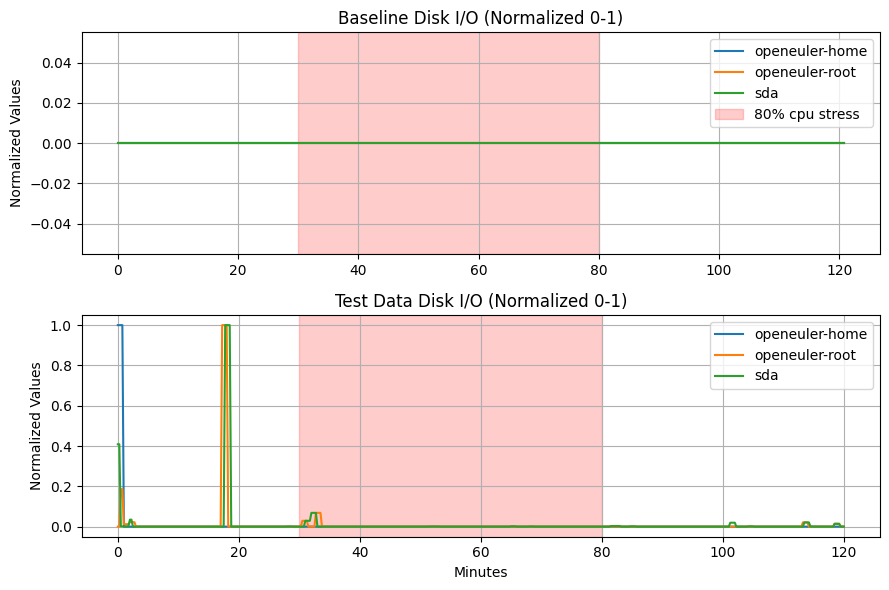

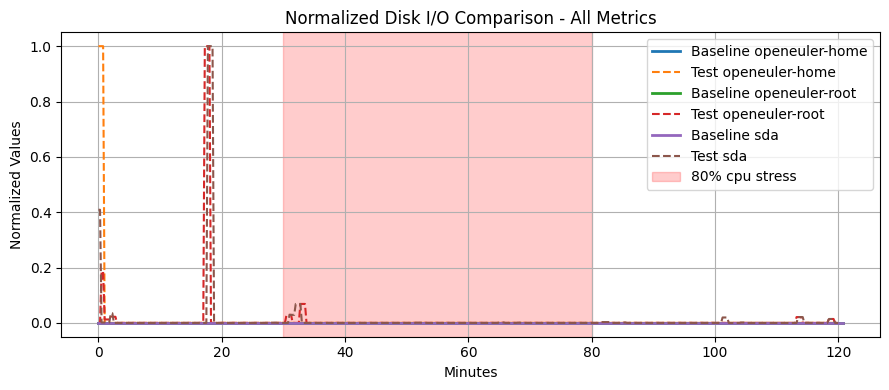

In [14]:
df_read_bytes["Minutes"] = (df_read_bytes["Time"] - df_read_bytes["Time"].min()).dt.total_seconds() / 60
df_baseline_read_bytes["Minutes"] = (df_baseline_read_bytes["Time"] - df_baseline_read_bytes["Time"].min()).dt.total_seconds() / 60

delay = 30  # 30 minutes (1800 seconds)
duration = 50  # 50 minutes (3000 seconds)

# Get columns to analyze
cols = ['openeuler-home', 'openeuler-root', 'sda']

# Create normalization function
def normalize_df(df, columns):
    df_norm = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:
            df_norm[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            df_norm[col] = 0
    return df_norm

# Normalize the data
df_baseline_norm = normalize_df(df_baseline_read_bytes, cols)
df_read_norm = normalize_df(df_read_bytes, cols)

# Create figure for normalized line plots - one for each dataset
plt.figure(figsize=(9, 6))

# Top subplot for baseline
plt.subplot(2, 1, 1)
for col in cols:
    plt.plot(df_baseline_norm["Minutes"], df_baseline_norm[col], label=col)
plt.title("Baseline Disk I/O (Normalized 0-1)")
plt.ylabel("Normalized Values")
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="80% cpu stress")
plt.grid(True)
plt.legend(loc='upper right')

# Bottom subplot for test
plt.subplot(2, 1, 2)
for col in cols:
    plt.plot(df_read_norm ["Minutes"], df_read_norm [col], label=col)
plt.title("Test Data Disk I/O (Normalized 0-1)")
plt.xlabel("Minutes")
plt.ylabel("Normalized Values")
plt.grid(True)
plt.legend(loc='upper right')
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="80% cpu stress")
plt.tight_layout()

# Create a separate figure for all columns comparison
plt.figure(figsize=(9, 4))
for col in cols:
    plt.plot(df_baseline_norm["Minutes"], df_baseline_norm[col], label=f"Baseline {col}", linewidth=2)
    plt.plot(df_read_norm ["Minutes"], df_read_norm [col], label=f"Test {col}", linewidth=1.5, linestyle='--')
plt.title("Normalized Disk I/O Comparison - All Metrics")
plt.xlabel("Minutes")
plt.ylabel("Normalized Values")
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="80% cpu stress")
plt.grid(True)
plt.legend()
plt.tight_layout()

## write bytes

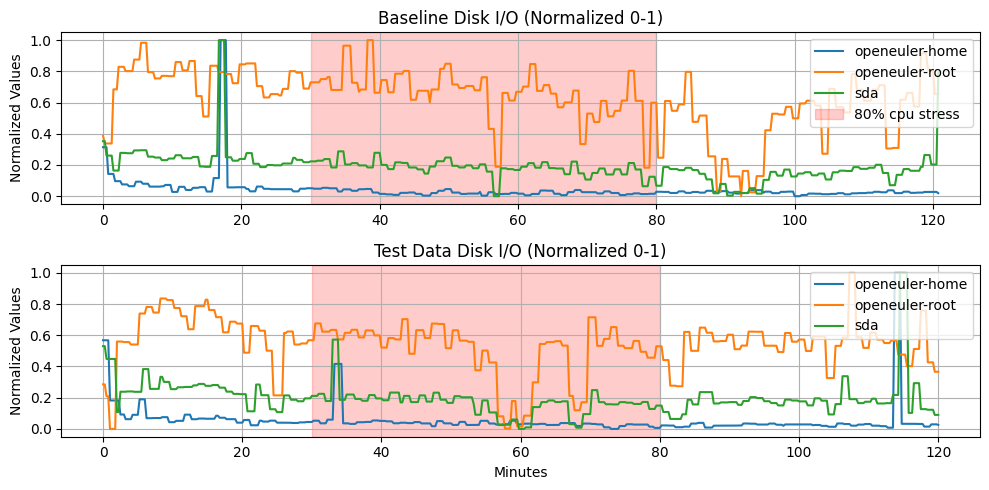

In [15]:
df_write_bytes["Minutes"] = (df_write_bytes["Time"] - df_write_bytes["Time"].min()).dt.total_seconds() / 60
df_baseline_write_bytes["Minutes"] = (df_baseline_write_bytes["Time"] - df_baseline_write_bytes["Time"].min()).dt.total_seconds() / 60

delay = 30  
duration = 50  

cols = ['openeuler-home', 'openeuler-root', 'sda']

def normalize_df(df, columns):
    df_norm = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:
            df_norm[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            df_norm[col] = 0
    return df_norm

df_baseline_norm = normalize_df(df_baseline_write_bytes, cols)
df_write_bytes_norm= normalize_df(df_write_bytes, cols)

plt.figure(figsize=(10, 5))

# Top subplot for baseline
plt.subplot(2, 1, 1)
for col in cols:
    plt.plot(df_baseline_norm["Minutes"], df_baseline_norm[col], label=col)
plt.title("Baseline Disk I/O (Normalized 0-1)")
plt.ylabel("Normalized Values")
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="80% cpu stress")
plt.grid(True)
plt.legend(loc='upper right')

# Bottom subplot for test
plt.subplot(2, 1, 2)
for col in cols:
    plt.plot(df_write_bytes_norm["Minutes"], df_write_bytes_norm[col], label=col)
plt.title("Test Data Disk I/O (Normalized 0-1)")
plt.xlabel("Minutes")
plt.ylabel("Normalized Values")
plt.grid(True)
plt.legend(loc='upper right')
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="80% cpu stress")
plt.tight_layout()